In [1]:
import sklearn
import numpy as np
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
from clustering import K_means_clustering

In [2]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, cache = False)

In [9]:
def equilidean_distance(X, val):
    return list(map(lambda x: np.sum((np.abs(X - x))**2), val))

In [9]:
from itertools import product, permutations, combinations
import random

### Cluster initialization

The accuracy of K-means clustering depends on a better cluster initialization. 
If the centroids of the initialized clusters are very different from each other, then we can expect the clustering algorithm to better perform.
Hence, we find 10 samples from the entire dataset randomly and calculate the equilidean distance between them. We repeat this many times and choose the set with maximum equilidean distance. The chosen set should have the distinct centroids.

In [145]:
def K_means_clustering(X, y, subset, max_iter = 50, tolerance = 1e-16):

    max_distance = []
    positions = []
    for i in range(100):
        random_positions = random.sample(range(len(X)), 100)
        combos = []
        for i in range(10):
            combos.append(sum([np.sum((X[indices[0]] - X[indices[1]]) **2) for indices in list(combinations(random_positions[10 * i: 10 * (i+1)], 2))]))
            max_index = np.argmax(combos)
            positions.append(random_positions[10 * max_index: 10 * (max_index+1)])
            max_distance.append(combos[np.argmax(combos)])

    centroids = []
    clusters = {}
    for i, index in enumerate(positions[np.argmax(max_distance)]):
        centroids.append(X[index])
        clusters[i] = [X[index]]

    data_distances_to_centroids = np.zeros((subset, 10))

    for cluster_index in list(clusters.keys()): 
        data_distances_to_centroids[:, cluster_index] = np.sum((X[:subset] - centroids[cluster_index])**2, axis = 1)

    old_residual = np.sum(data_distances_to_centroids)
    residual = old_residual + 1
    no_iterations = 0

    while np.abs(old_residual - residual) > tolerance and (no_iterations < max_iter):

        min_distance = np.argmin(data_distances_to_centroids, axis = 1)

        for i in list(clusters.keys()):
            clusters[i] = X[min_distance == i]
            

        centroids = np.array([np.mean(cluster, axis = 0) for _, cluster in clusters.items()])

        for cluster_index in list(clusters.keys()): 
            data_distances_to_centroids[:, cluster_index] = np.sum((X[:subset] - centroids[cluster_index])**2, axis = 1)
        
        old_residual = residual
        residual = np.sum(data_distances_to_centroids)
        
        no_iterations += 1

    return centroids, min_distance
            

In [146]:
%%time

centroids, minimum_distance = K_means_clustering(X, y, len(X), max_iter = 50, tolerance = 1e-6)

CPU times: user 2min 13s, sys: 1min 13s, total: 3min 27s
Wall time: 3min 44s


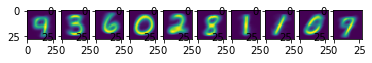

In [147]:
fig, ax = plt.subplots(1, 10)
for i in range(10):
    ax[i].imshow(centroids[i].reshape(28, -1))

In [148]:
digit = np.zeros((10, ), dtype = int)
count = np.zeros((10, ), dtype = int)
cardinality = np.zeros((10, ), dtype = int)
for i in range(10):
    unique_digits = np.unique(y[min_distance == i], return_counts = True)
    digit[i] = unique_digits[0][np.argmax(unique_digits[1])]
    count[i] = unique_digits[1][np.argmax(unique_digits[1])]
    cardinality[i] = sum(unique_digits[1])

accuracy = (sum(count)/ sum(cardinality)) * 100 # %
print(accuracy)

59.93714285714285


0.5997

In [137]:
digit

array([3, 3, 7, 1, 4, 6, 8, 2, 0, 6])

In [ ]:
for i, cluster in clusters.items():
        removed_item = 0
        

        min_distance = [np.argmin(equilidean_distance(item, centroids[changed_cluster])) for item in cluster]
        changed_cluster = []
        for sub_index, cluster_index in enumerate(min_distance):
            if i != cluster_index:
                changed_cluster.append(cluster_index)
                clusters[cluster_index].append(cluster.pop(sub_index-removed_item))
                removed_item += 1
                if len(clusters[cluster_index])>1:
                    centroids[cluster_index] = np.mean(clusters[cluster_index], axis = 0)
                else centroids[cluster_index] = clusters[cluster_index][0]

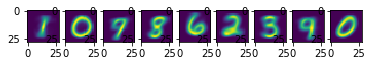

In [88]:
fig, ax = plt.subplots(1, 9)
for i in range(9):
    ax[i].imshow(centroids[i].reshape(28, -1))

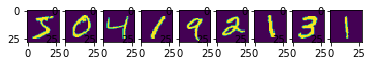

In [7]:
fig, ax = plt.subplots(1, 9)
for i in range(9):
    ax[i].imshow(X[i].reshape(28, -1))

X has 70000 rows and 784 columns. Each row represents a handwritten digit (0 - 9) as 28 * 28 (784) pixels shaped image.
y represents the digit written in an image of row as a string. 

In [50]:
distance.shape

(10, 784)

In [ ]:
def K_means_clustering(data, clusters):
    '''
    Cluster data using K-means clustering algorithm

    Input:
    -------
    data: Input data as flattened (N x 1 array)
    clusters: No. of clusters (dict); keys represents the label of clusters and values are empty

    Output:
    -------
    Clustered data (dict); keys are the cluster labels and values are the pixel index belonging to a cluster
    '''
    _, counts = np.unique(data, return_counts = True)
    sorted_counts = np.argsort(counts)[::-1]

    centroids = 


    tol = 1
    previous_tol = 2

    no_of_iterations = 0

    while np.abs(tol) > 0 and np.abs(previous_tol - tol) > 0.0:

        no_of_iterations += 1
        
        distance_to_centers = np.zeros((len(data), len(centers)))

        for i, center in enumerate(centers):
            distance_to_centers[:, i] = (data - center)**2 
        
        clusters = {}
        minimum_distance = np.argmin(distance_to_centers, axis = 1)

        for i, dist in enumerate(np.unique(minimum_distance)):
            clusters[dist] = np.where(minimum_distance == dist)[0]

        assert sum([len(x) for x in clusters.values()]) == len(data)

        previous_tol = tol

        tol = 0.0
        centers = []
        for i in list(clusters.keys()):
            centers.append(sum(data[clusters[i]])/len(clusters[i]))
            tol += sum((data[clusters[i]] - centers[i])**2)

    print("Converged in: %d iterations", no_of_iterations)

    return clusters

5


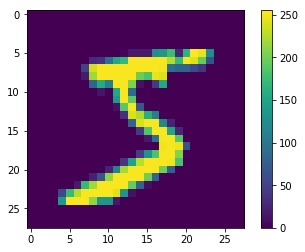

In [3]:
plt.imshow(X[0].reshape(28, -1))
print(y[0])
plt.colorbar()

In [49]:
%%time

clusters = {0: None, 1: None}
data = X[453]
clusters = K_means_clustering(data, clusters)

Converged in: %d iterations 3
CPU times: user 4.17 ms, sys: 54.1 ms, total: 58.2 ms
Wall time: 171 ms


In [50]:
clustered_data = np.zeros((len(data), 1))

clustered_data[clusters[0]] = 0
clustered_data[clusters[1]] = 1

0


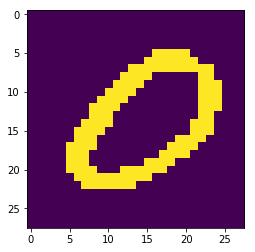

In [51]:
plt.imshow(clustered_data.reshape(28, -1))
print(y[453])

In [58]:
clusters = {}
for i in range(10):
    clusters[i] = [X[i]]

In [61]:
def K_means_clustering(data, clusters):
    '''
    Cluster data using K-means clustering algorithm

    Input:
    -------
    data: Input data as flattened (N x 1 array)
    clusters: No. of clusters (dict); keys represents the label of clusters and values are empty

    Output:
    -------
    Clustered data (dict); keys are the cluster labels and values are the pixel index belonging to a cluster
    '''

    centers = np.zeros((len(clusters), len(data)))

    
    for label, cluster in clusters.items():
        if len(cluster) > 1:
            centers[i] = np.sum(cluster, axis = 0) / len(cluster) # Find the centroid as the mean of the cluster
        else:
            centers[i] = cluster
    tol = 1
    previous_tol = 2

    no_of_iterations = 0

    while np.abs(tol) > 0 and np.abs(previous_tol - tol) > 0.0:

        no_of_iterations += 1
        
        distance_to_centers = np.zeros((len(clusters), 1))

        for i, center in enumerate(centers):
            distance_to_centers[i] = sum((data - center)**2)
        
        clusters = {}
        closest_cluster = np.argmin(distance_to_centers)
        clusters[closest_cluster].append(data)

        previous_tol = tol

        tol = 0.0
        centers = []
        
        centers[closest_cluster] = sum(clusters[closest_cluster])/len(clusters[closest_cluster]))
        tol += sum((data[clusters[i]] - centers[i])**2)

    print("Converged in: %d iterations", no_of_iterations)

    return clusters


[array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0., 

### Kernelized k-means clustering

In [7]:
from clustering import polynomial_kernel

data = X[453]

clusters = {0: np.hstack((range(200), range(600,len(data)))) ,
1: range(200, 600)
}

clusters = kernelized_k_means_clustering(data, clusters, kernel = polynomial_kernel)

Converged in: %d iterations 4


In [8]:
clustered_data = np.zeros((len(data), 1))

clustered_data[clusters[0]] = 0
clustered_data[clusters[1]] = 1

0


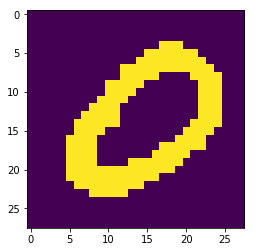

In [9]:
plt.imshow(clustered_data.reshape(28, -1))
print(y[453])

In [31]:
def exponential_kernel(x1, x2, p):
    return np.exp(-p * sum((x1 - x2)**2))


In [34]:
A = np.array([1, 2])
B = np.array([[3, 4], [5, 6]])

In [44]:
np.sum((X[0] - X[0:])**2, axis = 1)

array([      0., 5698302., 7690356., ..., 6904090., 7254810., 8667960.])

In [ ]:
adjacency_matrix = np.zeros((X.shape[0], X.shape[0]))

for i in range(X.shape[0]):
    adjacency_matrix[i] = np.exp(-1 * np.sum((X[i] - X[0:])**2, axis = 1))